Chargement des librairies

In [ ]:
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import convolve2d

On définit deux fonctions :
- **creation_matrice_ref** qui permet de générer une matrice de taille n x n qui correspond à la moyenne de 1000 matrices pour la zone extérieure, 10000 matrices pour la zone entre le centre et l'extérieur et 100000 matrices pour le centre. Les valeurs de chaque matrice sont simulées selon une loi normale centrée réduite.
- **creation_matrice_bruit** qui génère une matrice semblable à celle de creation_matrice_ref mais avec un bruit centré et d'écart-type sd en plus.

In [ ]:
def creation_matrice_ref(n):
    nb_mat_exterieur = 1000
    matrices_exterieur = [np.random.randn(n, n) for _ in range(nb_mat_exterieur)]
    mean_mat_exterieur = sum(matrices_exterieur) / nb_mat_exterieur
    mean_mat_exterieur[n//5:4*n//5, n//5:4*n//5] = 0

    nb_mat_milieu = 10000
    matrices_milieu = [np.random.randn(3*n//5, 3*n//5) for _ in range(nb_mat_milieu)]
    mean_mat_milieu = sum(matrices_milieu) / nb_mat_milieu
    mean_mat_milieu[n//5:2*n//5, n//5:2*n//5] = 0

    mat_temporaire = np.zeros((n, n))
    mat_temporaire[n//5:4*n//5, n//5:4*n//5] = mean_mat_milieu
    mean_mat_milieu = mat_temporaire

    nb_mat_interieur = 100000
    matrices_interieur = [np.random.randn(n//5, n//5) for _ in range(nb_mat_interieur)]
    mean_mat_interieur = sum(matrices_interieur) / nb_mat_interieur

    mat_temporaire = np.zeros((n, n))
    mat_temporaire[2*n//5:3*n//5, 2*n//5:3*n//5] = mean_mat_interieur
    mean_mat_interieur = mat_temporaire

    return mean_mat_exterieur + mean_mat_milieu + mean_mat_interieur


def creation_matrice_bruit(n, sd):
    nb_mat_exterieur = 1000
    matrices_exterieur = [
        np.random.randn(n, n) + np.random.normal(0, sd, (n, n))
        for _ in range(nb_mat_exterieur)
    ]
    mean_mat_exterieur = sum(matrices_exterieur) / nb_mat_exterieur
    mean_mat_exterieur[n//5:4*n//5, n//5:4*n//5] = 0

    nb_mat_milieu = 10000
    matrices_milieu = [
        np.random.randn(3*n//5, 3*n//5) + np.random.normal(0, sd, (3*n//5, 3*n//5))
        for _ in range(nb_mat_milieu)
    ]
    mean_mat_milieu = sum(matrices_milieu) / nb_mat_milieu
    mean_mat_milieu[n//5:2*n//5, n//5:2*n//5] = 0

    mat_temporaire = np.zeros((n, n))
    mat_temporaire[n//5:4*n//5, n//5:4*n//5] = mean_mat_milieu
    mean_mat_milieu = mat_temporaire

    nb_mat_interieur = 100000
    matrices_interieur = [
        np.random.randn(n//5, n//5) + np.random.normal(0, sd, (n//5, n//5))
        for _ in range(nb_mat_interieur)
    ]
    mean_mat_interieur = sum(matrices_interieur) / nb_mat_interieur

    mat_temporaire = np.zeros((n, n))
    mat_temporaire[2*n//5:3*n//5, 2*n//5:3*n//5] = mean_mat_interieur
    mean_mat_interieur = mat_temporaire

    return mean_mat_exterieur + mean_mat_milieu + mean_mat_interieur

On définit les métriques classiques qui permettent d'évaluer la différence entre deux images (représentées ici par des matrices) :

In [ ]:
def mse(A, B):
    return np.mean((A - B)**2)

def mae(A, B):
    return np.mean(np.abs(A - B))

def t_test_value(A, B):
    tval, _ = ttest_ind(A.ravel(), B.ravel())
    return tval

def t_test_pvalue(A, B):
    _, pval = ttest_ind(A.ravel(), B.ravel())
    return pval



def ssim_small(img1, img2, K1=0.01, K2=0.03, L=1, window_size=10, sigma=1):
    """
    Calcule le SSIM (Structural Similarity Index) entre deux images img1 et img2.

    Parameters :
        img1, img2 : images (matrices numpy)
        K1, K2     : constantes de stabilisation
        L          : plage dynamique des valeurs (ici on normalise donc L=1)
        window_size : taille du noyau gaussien utilisé pour lisser (fenêtre)
        sigma      : écart-type du noyau gaussien

    Return :
        SSIM moyen entre les deux images (float)
    """

    # Normalisation dans [0,1]
    def normalize(x):
        return (x - np.min(x)) / (np.max(x) - np.min(x))

    img1 = normalize(img1)
    img2 = normalize(img2)

    # Construction d'un noyau gaussien pour le lissage local
    half = window_size // 2
    coords = np.arange(-half, half+1)
    # Noyau gaussien : window[i, j] = exp(-(i² + j²) / (2 sigma²))
    window = np.exp(-(coords[:, None]**2 + coords[None, :]**2) / (2 * sigma**2))
    window /= np.sum(window)

    # Convolution avec gestion des bords
    # "same" : même taille que l’image
    # "symm" : symétrie des bords
    conv = lambda X: convolve2d(X, window, mode='same', boundary='symm')

    # Moyennes locales
    mu1 = conv(img1)
    mu2 = conv(img2)

    # Variances et covariance locales
    sigma1_sq = conv(img1**2) - mu1**2
    sigma2_sq = conv(img2**2) - mu2**2
    sigma12   = conv(img1 * img2) - mu1 * mu2

    # Termes de stabilisation (évite les divisions par zéro)
    C1 = (K1*L)**2
    C2 = (K2*L)**2

    # Formule du SSIM pixel par pixel
    ssim_map = ((2*mu1*mu2 + C1) * (2*sigma12 + C2)) / \
               ((mu1**2 + mu2**2 + C1) * (sigma1_sq + sigma2_sq + C2))

    # Retourne le SSIM moyen sans les valeurs NaN aux bords
    return np.nanmean(ssim_map)



def gamma_index(A, B, dose_diff_crit=0.03, dist_crit=3, pixel=1):
    """
    Calcule l'indice gamma entre deux matrices A et B qui représentent des cartes de dose.

    Parameters :
    -----------
    A, B : matrices numpy
    dose_diff_crit : float
        Critère de différence de dose 
    dist_crit : float
        Critère de glissement spatial entre les pixels (mm)
    pixel : float
        Taille d’un pixel (mm), utilisé pour convertir en distance réelle

    Return :
    --------
    gamma_map : matrice contenant, pour chaque pixel (i,j),
                la valeur minimale du gamma par rapport à tous les autres.
    """

    # Dimensions des matrices
    nr, nc = A.shape

    # Meshgrid permet de vectoriser les calculs de distance
    x = np.arange(nr)
    y = np.arange(nc)
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Carte gamma initialisée à zéro (remplie pixel par pixel)
    gamma_map = np.zeros((nr, nc))

    for i in range(nr):
        for j in range(nc):
            # Calcul des distances et différences de dose entre le pixel (i,j) de la matrice A
            # et tous les pixels de la matrice B
            dist = np.sqrt((pixel * (X - i))**2 + (pixel * (Y - j))**2)
            dose_diff = np.abs(A[i, j] - B)

            # Calcul de la matrice gamma pour le pixel (i,j)
            gamma_matrix = np.sqrt(
                (dose_diff / dose_diff_crit)**2 +
                (dist / dist_crit)**2
            )

            # Valeur minimale du gamma pour le pixel (i,j)
            gamma_map[i, j] = np.min(gamma_matrix)

    return gamma_map


def calcul_distances(matrice_reference, matrice_test):

    MSE  = mse(matrice_reference, matrice_test)
    MAE  = mae(matrice_reference, matrice_test)
    tval = t_test_value(matrice_reference, matrice_test)
    pval = t_test_pvalue(matrice_reference, matrice_test)
    SSIM = ssim_small(matrice_reference, matrice_test)
    GAMMA = gamma_index(matrice_reference, matrice_test)

    return {
        "MSE": MSE,
        "MAE": MAE,
        "t_value": tval,
        "p_value": pval,
        "SSIM": SSIM,
        "gamma_pass_rate": np.mean(GAMMA < 1),
    }

On exécute les fonctions en utilisant des matrices carrées de longueur n = 100.

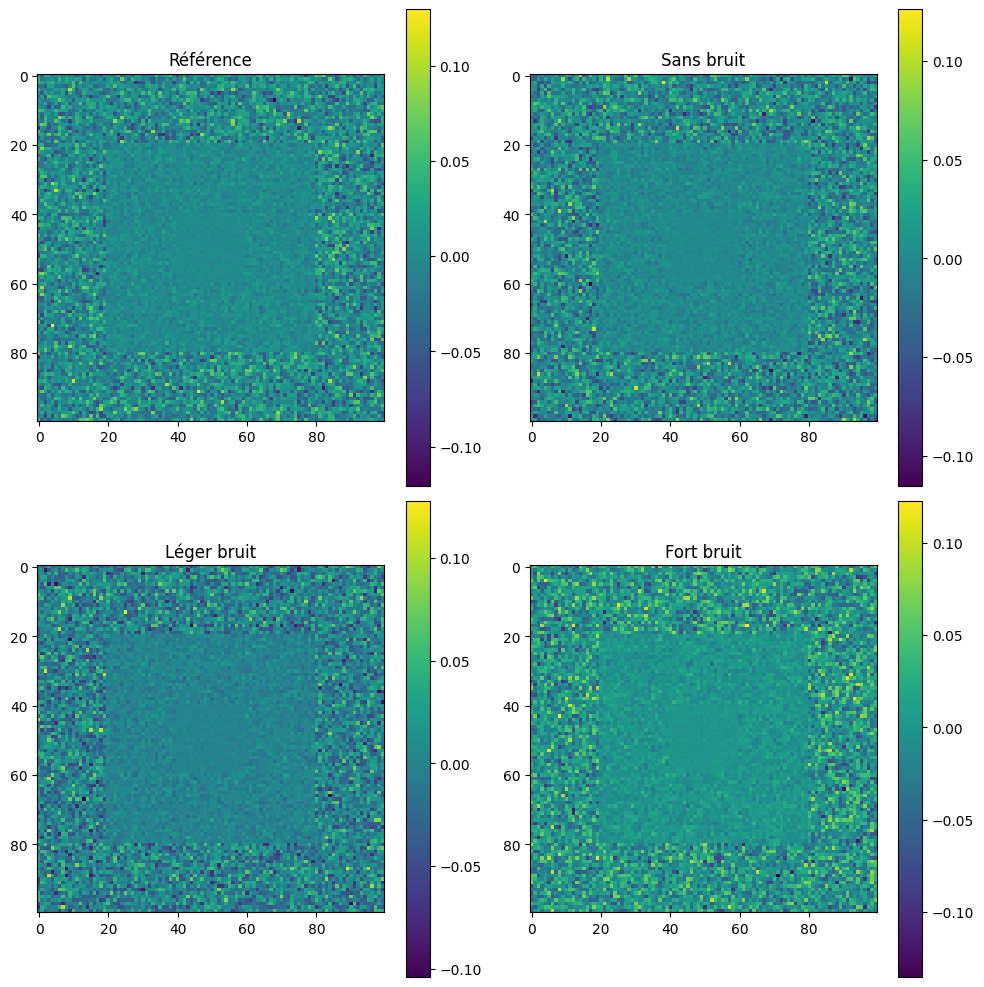

                  MSE       MAE   t_value   p_value      SSIM  gamma_pass_rate
Sans bruit   0.001334  0.026430  2.310411  0.020876  0.169482           0.9879
Léger bruit  0.001356  0.026775  1.206727  0.227552  0.152211           0.9883
Fort bruit   0.001539  0.028502  0.484244  0.628218  0.157112           0.9924


C:\Users\13971\AppData\Local\Temp\ipykernel_23420\2743611828.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: float(x))


In [ ]:
np.random.seed(123)
n = 100

matrice_reference = creation_matrice_ref(n)
matrice_test_sans_bruit = creation_matrice_ref(n)
matrice_test_leger_bruit = creation_matrice_bruit(n, 0.05)
matrice_test_fort_bruit = creation_matrice_bruit(n, 0.5)



plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.title("Référence")
plt.imshow(matrice_reference, cmap='viridis')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.title("Sans bruit")
plt.imshow(matrice_test_sans_bruit, cmap='viridis')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.title("Léger bruit")
plt.imshow(matrice_test_leger_bruit, cmap='viridis')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.title("Fort bruit")
plt.imshow(matrice_test_fort_bruit, cmap='viridis')
plt.colorbar()

plt.tight_layout()
plt.show()




result_sans_bruit = calcul_distances(matrice_reference, matrice_test_sans_bruit)
result_leger_bruit = calcul_distances(matrice_reference, matrice_test_leger_bruit)
result_fort_bruit = calcul_distances(matrice_reference, matrice_test_fort_bruit)


resultats = {
    "Sans bruit": result_sans_bruit,
    "Léger bruit": result_leger_bruit,
    "Fort bruit": result_fort_bruit
}

df = pd.DataFrame(resultats).T
df = df.map(lambda x: float(x))

print(df)